# Guess Core and use other methods to interpolate

In [13]:
import os, sys
import pickle
from scf_guess_tools import  Backend, load, calculate
import numpy as np
import matplotlib.pyplot as plt
from BlockMatrix import BlockMatrix


In [2]:
with open('../c5h4n2o2/models/test_data.pkl', 'rb') as f:
    test = pickle.load(f)
with open('../c5h4n2o2/models/train_data.pkl', 'rb') as f:
    train = pickle.load(f) # fock, overlap, file, density
train_X = np.array([overlap for _, overlap, _, _ in train])
train_y = np.array([fock for fock, _, _, _ in train])
test_X = np.array([overlap for _, overlap, _, _ in test])
test_y = np.array([fock for fock, _, _, _ in test])
train_files = np.array([file for _, _, file, _ in train])
test_files = np.array([file for _, _, file, _ in test])
train_densities = np.array([density for _, _, _, density in train])
test_densities = np.array([density for _, _, _, density in test])
mat_dim = train_X[0].shape[0]
mat_dim


49

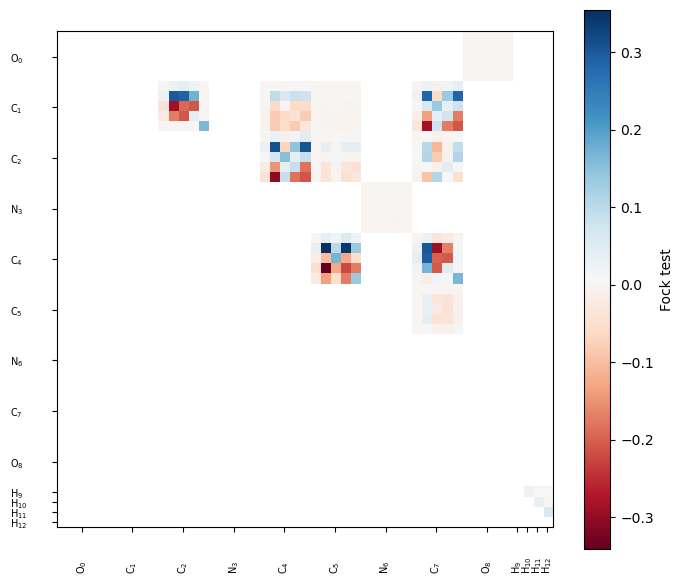

np.float64(49.0)

In [3]:
mol = load(train_files[10], Backend.PY).native
dm = BlockMatrix(mol, train_X[10]) # can also override the matrix
dm.plot_blocks_by_type("homo", labels="atoms", figsize=(8, 7), title="Fock test", imshow_args={"cmap": "RdBu"})
dm.Matrix.trace()

## First Trial
Just learn the Fock center Block-matrix for the general Case for all given elements! 

In [4]:
elements = ["C", "N", "O", "H"]
training_centers_X = {"C":[], "N":[], "O":[], "H":[]}
training_centers_y = {"C":[], "N":[], "O":[], "H":[]}
test_centers_X = {"C":[], "N":[], "O":[], "H":[]}
test_centers_y = {"C":[], "N":[], "O":[], "H":[]}

for fock, overlap, file, _ in train:
    mol = load(file, Backend.PY).native
    dmX = BlockMatrix(mol, overlap)
    dmY = BlockMatrix(mol, fock)
    for element in elements:
        for block in dmX.get_blocks_by_atom(element, block_type="center"):
            training_centers_X[element].append(block)
        for block in dmY.get_blocks_by_atom(element, block_type="center"):
            training_centers_y[element].append(block)

for fock, overlap, file, _ in test:
    mol = load(file, Backend.PY).native
    dmX = BlockMatrix(mol, overlap)
    dmY = BlockMatrix(mol, fock)
    for element in elements:
        for block in dmX.get_blocks_by_atom(element, block_type="center"):
            test_centers_X[element].append(block)
        for block in dmY.get_blocks_by_atom(element, block_type="center"):
            test_centers_y[element].append(block)


True

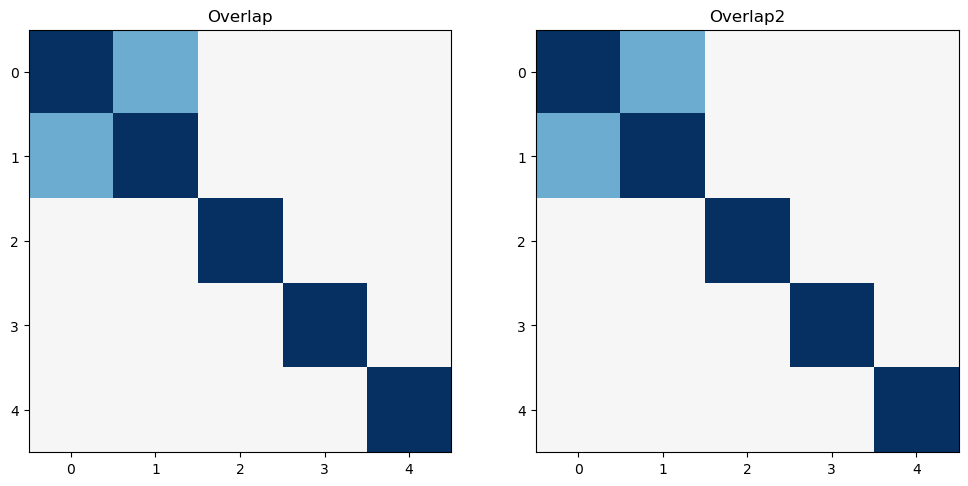

In [22]:
c_s = training_centers_X["C"]
for i in range(len(c_s)):
    diff = c_s[0] - c_s[i]
    if diff.sum() != 0: 
        print("Not equal")
# it seems that everything in sto-3g is actually the same
mol1 = load(train_files[0], Backend.PY).native
mol2 = load(train_files[1], Backend.PY).native
center1 = BlockMatrix(mol1)
center2 = BlockMatrix(mol2)
mean_c_ovlp1 = np.mean(center1.get_blocks_by_atom("C", block_type="center"), axis=0)
mean_c_ovlp2 = np.mean(center2.get_blocks_by_atom("C", block_type="center"), axis=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mean_c_ovlp1, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[0].set_title("Overlap")
ax[1].imshow(mean_c_ovlp1, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].set_title("Overlap2")
np.allclose(mean_c_ovlp1, mean_c_ovlp2)

In [11]:
# try different basis sets
ex_overlap, ex_fock, ex_density = [], [], []
mols = []
for i, file in enumerate(train_files[:5]):
    mol = load(file, Backend.PY)
    mols.append(mol)
    wf = calculate(mol, basis="6-31g", guess="minao", method="dft", functional="b3lypg")
    ex_overlap.append(wf.overlap())
    ex_fock.append(wf.fock())
    ex_density.append(wf.density())


converged SCF energy = -452.712890207529
converged SCF energy = -452.630906802163
converged SCF energy = -452.619631213144
converged SCF energy = -452.720086127981
converged SCF energy = -452.642850787733


True


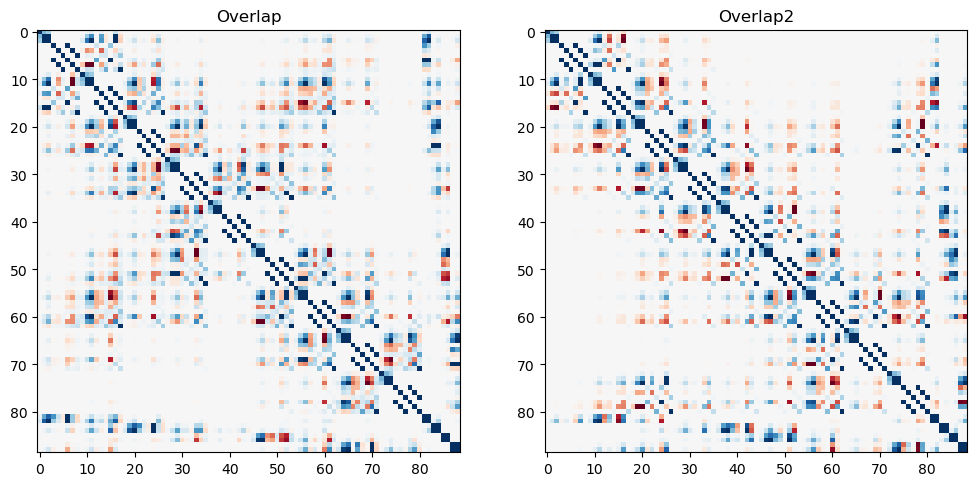

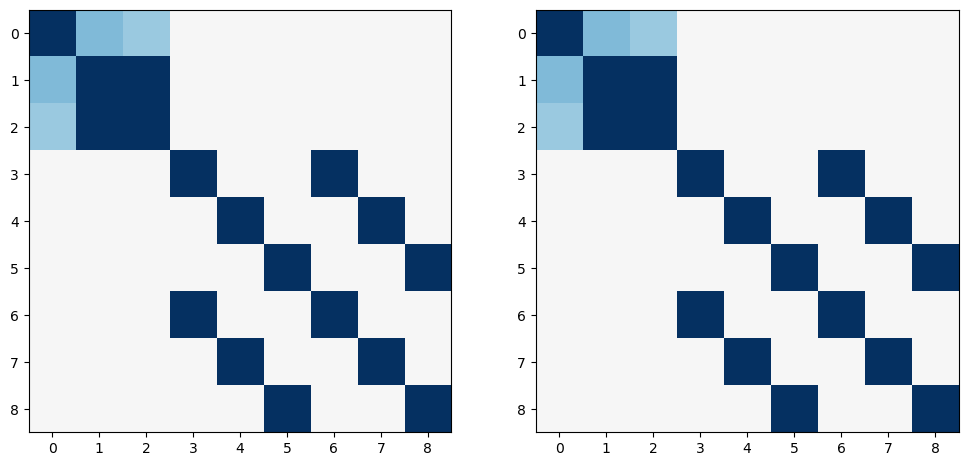

In [ ]:
ex1, ex2 = 0,3
center1 = BlockMatrix(mols[ex1].native, ex_overlap[ex1].numpy)
center2 = BlockMatrix(mols[ex2].native, ex_overlap[ex2].numpy)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(center1.Matrix, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[0].set_title("Overlap")
ax[1].imshow(center2.Matrix, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].set_title("Overlap2")

# They are also the SAME!!!
c_mean1 = np.mean(center1.get_blocks_by_atom("C", block_type="center"), axis=0)
c_mean2 = np.mean(center2.get_blocks_by_atom("C", block_type="center"), axis=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(c_mean1, cmap="RdBu", vmin=-0.5, vmax=0.5)
# ax[0].set_title("Overlap mean")
# ax[1].imshow(c_mean2, cmap="RdBu", vmin=-0.5, vmax=0.5)
# ax[1].set_title("Overlap2 mean")
# np.allclose(c_mean1, c_mean2)
c1 = center1.get_blocks_by_atom("C", block_type="center")[0]
c2 = center1.get_blocks_by_atom("C", block_type="center")[2]
print(np.allclose(c1, c2))
ax[0].imshow(c1, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].imshow(c2, cmap="RdBu", vmin=-0.5, vmax=0.5)